In [ ]:
import math
import pandas as pd
from scipy.optimize import minimize_scalar
import numpy as np
from Bio.SeqUtils.IsoelectricPoint import IsoelectricPoint as IP
from Bio import Entrez
from Bio import SeqIO
from io import StringIO
import re
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from scipy.integrate import solve_ivp
#data
L= 0.135 # module length in meters
n_f = 6 #number of fibers
A = 0.0032 #m2
i_d = 1.27e-3#internal diameter m
delta_membrane = 0.325e-3 #m
p_s = 0.1e-6 #pore size in meters
T = 298 #K
V_1 = 50e-6 #m3
V_2 = 500e-6 #m3
R = 8.314 #J/mol/K
F = 96485 #C/mol
e = 1.60217662e-19 #C
porosity = 0.85
pH =9
permitivity = 6.375e-10 #permitivity of the medium C^2(J.m)^-1
I = 7.5 #ionic strength mM
# gamma_w = 32400#shear rate s-1
phi_m = 0.68
eta_0 = 0.000905#Pa.second viscosity of hte TGM
rho_p = 1300 #kg/m3 density of the particles
rho_f = 1000 #kg/m3 density of the fluid
k_B = 1.38064852e-23 #J/mol/K Boltzmann constant
phi_w_guess = [0.64,0.64,0.64] #guess for the volume fraction of solute at the membrane wall

Re = 1500
# Particle sizes (in meters)
particles = [
    {'name': '10nm', 'radius': 10e-9, 'phi_b': 0.01},
    {'name': '180nm', 'radius': 180e-9, 'phi_b': 0.05},
    {'name': '300nm', 'radius': 300e-9, 'phi_b': 0.06}
]
phi_w_dict={key:values for key, values in zip([particle['radius'] for particle in particles], phi_w_guess)}
target_species = 10e-9 
#equations
#Step 2 - evaluate the viscosity
    # no particle-particle interactions - dillute suspensions
def viscosity_no_PP(eta_0,phi_b,k1):
    """eta_0 - viscosity of the dispersion medium
    phi - volume in parts occupied by the dispersed solid
    k1 = shape factor"""
    if phi_b<0.1:
        eta_phi = eta_0*(1+5/2*phi_b)
    elif phi_b>=0.1:
        eta_phi = eta_0*(1+5/2*phi_b+k1*phi_b**2)
    return eta_phi
  

def max_agg_packing (phi_m):
    phi_Max=phi_m+0.74*(1-phi_m)
    return phi_Max
phi_M = max_agg_packing(phi_m)

eta_f= viscosity_no_PP(eta_0,0.12,10)
V_ax = Re*eta_f/(rho_f*i_d) 
gamma_w = (8*V_ax)*1.95/i_d


def J_brownian(a, phi_w, phi_b):
    numerator = gamma_w * (k_B ** 2) * (T ** 2)
    denominator = (eta_f ** 2) * (a ** 2) * L
    term = (numerator / denominator) ** (1/3)
    J = 0.114 * term * (math.log((abs(phi_w / phi_b))))
    return J

# Function to calculate J for shear-induced diffusion
def J_shear(a, phi_w, phi_b):
    term = (a ** 4 / L) ** (1/3)
    log_term = math.log(abs(phi_w / phi_b))
    J = 0.078 * term * gamma_w * (log_term)
    return J

# Function to calculate J for inertial lift
def J_inertial(a):
    J = (0.036 * rho_p * (a ** 3) * (gamma_w ** 2)) / eta_f
    return J
#J solvent permeation flux (m/s)

net_charge = {} 
def get_protein_info(uniprot_code, pH):
    Entrez.email = "s230152@dtu.dk"
    handle = Entrez.esearch(db="protein", term=uniprot_code, retmax=1)
    record = Entrez.read(handle)
    handle.close()

    protein_id = record["IdList"][0]

    handle = Entrez.efetch(db="protein", id=protein_id, rettype="gb", retmode="text")
    record = handle.read()
    handle.close()

    seq_record = SeqIO.read(StringIO(record), "genbank")
    protein_sequence = seq_record.seq
    protein = IP(protein_sequence)

    iep = protein.pi()
    net_charge = protein.charge_at_pH(pH)

    return iep, net_charge
uniprot_code = {a:uniprot_code for a,uniprot_code in zip([particle['name'] for particle in particles],['P0DOX5','P02768','P05814'])}
net_charge = {}
for particle in particles:
    particle['iep'], particle['net_charge'] = get_protein_info(uniprot_code[particle['name']], pH)
    net_charge[particle['name']] = particle['net_charge']
# net_charge = {'10nm': 11.43, '180nm': -10.63, '300nm': -4.67} #ph 6.8
# L_p =(porosity*(p_s)**2)/(8*eta_f*delta_membrane)
L_p= 99/3600/1000/1000   
s = (( 5*eta_f* delta_membrane * L_p) /porosity)**(1/2)
k = (((permitivity*R*T)/(((F**2)*(2*I))))**(1/2))
lambda_aph_dict={}
for particle,charge in zip(particles,net_charge.values()):
    z = charge
    phi_b = particle['phi_b']
    a = particle['radius']
    lambda_aph = 1 - math.exp(-a/(2*s))

    
    delta_s = ((z)*e)/(4*math.pi*(a**2))
    eff_a = a + (((4*(a**3)*(delta_s**2))/(permitivity*k_B*T))*0.2*k)
    particle["radius"]=eff_a
    lambda_aph_dict[eff_a] = lambda_aph
# print(lambda_aph_dict)
target_species = particles[0]['radius']
phi_w_dict={key:values for key, values in zip([particle['radius'] for particle in particles], phi_w_guess)}
set_data = pd.DataFrame(columns=['name', 'radius', 'max_velocity', 'source'])


def min_flux(Particles, phi_w_list):
    """ have to put particles list with radius and phi_b,
    phi_w_list with phi_w
    results ai_target, J_flux and dataframe"""
    
    min_velocity = float('inf')
    selected_particle_radius = None
    velocities_list=[]

    for particle, phi_w in zip(Particles, phi_w_list):
        a = particle['radius']
        phi_b = particle['phi_b']
        
        # Calculate velocities
        brownian_velocity = J_brownian(a, phi_w, phi_b)
        shear_velocity = J_shear(a, phi_w, phi_b)
        inertial_velocity = J_inertial(a)
        
        # Find the maximum velocity
        max_velocity = max(brownian_velocity, inertial_velocity, shear_velocity)
        
        # Determine the source of the maximum velocity
        source = 'brownian' if max_velocity == brownian_velocity else 'inertial' if max_velocity == inertial_velocity else 'shear'
        
        # Update set_data by replacing previous row or adding a new one
        if particle['name'] in set_data['name'].values:
            set_data.loc[set_data['name'] == particle['name'], ['radius', 'max_velocity', 'source']] = [a, max_velocity, source]
        else:
            set_data.loc[len(set_data)] = [particle['name'], a, max_velocity, source]
        # Store all velocities in the DataFrame
        velocities_list.append({
            'name': particle['name'],
            'radius': a,
            'brownian_velocity': brownian_velocity,
            'shear_velocity': shear_velocity,
            'inertial_velocity': inertial_velocity
        })
        velocities_df=pd.DataFrame(velocities_list)
        # Check for the minimum velocity
        if max_velocity < min_velocity:
            min_velocity = max_velocity
            selected_particle_radius = a

    return selected_particle_radius, min_velocity, set_data,velocities_df

# Initialize variables for particles and inertial-lift properties
# ai_target, min_vel, dataf= min_flux(particles, phi_w_guess)

# Function to calculate φ_w for each particle size
def calculate_phi_w(Particles, a_target, min_velocity, data):
    count = 0
    # Dictionaries to store results
    phi_w_J_dict = {}
    phi_wjI_dict = {}
    inertial_particles = []
    
    for particle in Particles:
        a_particle = particle['radius']
        phi_b_particle = particle['phi_b']
        
        if a_particle != a_target:
            # Retrieve the velocity source from the data DataFrame
            source = data.loc[data['radius'] == a_particle, 'source'].values[0]
            
            max_velocity = data.loc[data['radius'] == a_particle, 'max_velocity'].values[0]
            if max_velocity >= 10 * min_velocity:
                # Handle inertial particles
                phi_wjI = 0
                phi_wjI_dict[a_particle] = phi_wjI
                phi_w_dict[a_particle] = phi_wjI
                phi_w_J_dict[a_particle] = phi_wjI
                inertial_particles.append((a_particle, phi_b_particle, max_velocity))
            if source == "inertial":
                count += 1
            else:

                    def objective_function(phi_w_particle):
                        max_velocity = max(J_brownian(a_particle, phi_w_particle, phi_b_particle),J_shear(a_particle, phi_w_particle, phi_b_particle))
                        return abs(max_velocity - min_velocity)
               
            #     # Minimize the objective function to find the optimal phi_w for the particle
                    if a_particle == min(phi_w_dict.keys()):
                        result = minimize_scalar(objective_function, bounds=(0, 0.74), method='bounded')
                    else:
                        result = minimize_scalar(objective_function, bounds=(0, 0.64), method='bounded')

                    if result.success:
                        phi_w_optimal = result.x
                        phi_w_dict[a_particle] = phi_w_optimal
                        phi_w_J_dict[a_particle] = phi_w_optimal
                    else:
                        print(f"Optimization failed for particle radius {a_particle:.1e} m")
    # Handle inertial particles after processing all particles
    if count == 1:
        for a, phi_b, u_j in inertial_particles:
            if phi_w_J_dict[a]!=0:
                phi_wjI = phi_M - sum(phi_w_J_dict.values())
                phi_wjI_dict[a] = phi_wjI
                phi_w_dict[a] = phi_wjI
    elif count > 1:
        total_u_j_inv = sum((phi_b / u_j) for _, phi_b, u_j in inertial_particles)
        phi_w_remaining = phi_M - sum(phi_w_J_dict.values())
        phi_w_jI_sum = sum((phi_b / u_j) / total_u_j_inv * phi_w_remaining for _, phi_b, u_j in inertial_particles)
        if abs(phi_M - (sum(phi_w_J_dict.values()) + phi_w_jI_sum)) > 1e-6:
            print("Warning: φ_M and the sum of φ_w_j do not match closely enough.")
        
        for a, phi_b, u_j in inertial_particles:
            if phi_w_J_dict[a]!=0:
                phi_wjI = (phi_b / u_j) / total_u_j_inv * phi_w_remaining
                phi_wjI_dict[a] = phi_wjI
                phi_w_dict[a] = phi_wjI

    return phi_w_dict


# Output the updated dictionary
#print(f"Updated phi_w_dict: {phi_w_dict}")
def packing_constraints(Particles, phi_w_list):
    ai_target, min_vel, dataf,vel= min_flux(Particles, phi_w_list)
    
    phi_w_updated=calculate_phi_w(Particles, ai_target, min_vel, dataf)
    tolerance = 1e-6  # Set a tolerance for convergence
    max_iterations = 100

    for i in range(max_iterations):
        remaining_phiw_j = {a: phi_w for a, phi_w in phi_w_updated.items() if a != min(phi_w_updated.keys())}
        phi_w_i = phi_w_updated[ai_target] # Wall concentration of the target particle
        # Check if packing constraints are satisfied
        if (phi_M >= sum(phi_w_updated.values())) and (sum(remaining_phiw_j.values()) <= 0.68):
            # print(f"Iteration {i}: Packing constraints are met.")
            return phi_w_updated,   min_vel, ai_target, dataf
        phi_w_previous = phi_w_updated.copy()
        # Update phi_w for the target particle
        phi_w_i_corrected = phi_M * (phi_w_i / sum(phi_w_updated.values()))
        
        phi_w_updated[ai_target] = phi_w_i_corrected
        phi_w_j = {a: phi_w for a, phi_w in remaining_phiw_j.items() if a != ai_target}
        if (sum(remaining_phiw_j.values()) <= 0.68)==False and ai_target in remaining_phiw_j.keys() and i>15:
            phi_w_updated[ai_target]=0.68 *(phi_w_updated[ai_target]/(sum(remaining_phiw_j.values())))
            # print(phi_w_updated[ai_target])
        if (phi_w_updated[min(phi_w_updated.keys())] <= 0.74 * (1 - sum(remaining_phiw_j.values()))) == False and ai_target==min(phi_w_updated.keys())  and i>15:
            phi_w_updated[min(phi_w_updated.keys()) ]= 0.74 * (1 - sum(remaining_phiw_j.values()))
        # Store the previous values of phi_w for comparison
        
        # print(phi_w_i_corrected)
        # Recalculate the flux and phi_w_j values after updating
        _, min_vel, dataf,vel= min_flux(particles, phi_w_updated.values())
        phi_w_updated=calculate_phi_w(particles, ai_target, min_vel, dataf)

        # Check for the change in phi_w values between iterations
        phi_w_diff = sum(abs(phi_w_updated[a] - phi_w_previous[a]) for a in phi_w_updated)

        # If the change in phi_w values is smaller than the tolerance, stop the iteration
        # if phi_w_diff < tolerance:
        #     print(f"Iteration {i}: Will not converger further.")
        #     return phi_w_updated,   min_vel, ai_target, dataf
    # If the loop completes without finding a solution
    # print("Warning: No solution found within the iteration limit.")

  
    return phi_w_updated, min_vel, ai_target, dataf

def J_flux_calculation(Particles, phi_w_list):
    # Unpack the results from packing_constraints
    phi_w_updated, J_flux, ai_target, dataf = packing_constraints(Particles, phi_w_list)
    # print(phi_w_updated)
    
    # Initialize J_pi with J_flux values from packing constraints for all particles
    J_pi = {a: J_flux for a in phi_w_updated.keys()}
    
    phi_w_dict_T = {}
    phi_w_dict_R = {}
    # Separate phi_w values into two dictionaries based on particle size comparison with p_s/2
    for (a, phi_w) in phi_w_updated.items():
        
        if a <= p_s / 2:
            phi_w_dict_T[a] = phi_w
            # print(phi_w_dict_T)
        else:
            phi_w_dict_R[a] = phi_w
            # print(phi_w_dict_R)

    # Update phi_w for particles in phi_w_dict_T based on ratio of min(phi_w_dict_R.keys()) / a
    for (a, phi_w) in phi_w_dict_T.items():
        if (min(phi_w_dict_R.keys()) / a )< 10:
            phi_w_updated[a] = 0.68 * (1 - sum(phi_w_dict_R.values()))
        else:
            phi_w_updated[a] = 0.74 * (1 - sum(phi_w_dict_R.values()))
    
    # Calculate J_pi only for particles in phi_w_dict_T
    for a , particle in zip(phi_w_dict_T.keys(), Particles):

        phi_b = particle['phi_b']
        
        # Calculate velocities
        brownian_velocity = J_brownian(a, phi_w_updated[a], phi_b)
        shear_velocity = J_shear(a, phi_w_updated[a], phi_b)
        inertial_velocity = J_inertial(a)
        
        # Update J_pi with the maximum velocity for particles in phi_w_dict_T
        max_velocity = max(brownian_velocity, inertial_velocity, shear_velocity)
        J_pi[a] = max_velocity

    return J_pi, phi_w_updated, J_flux, ai_target, dataf

# print(J_flux_calculation(particles, phi_w_guess))
#mass-transfer coefficient calculated from equation  1#step 10


def sieving_parameters(Particles, phi_w_list):
    
    J_pi,phi_w_updated, J_flux, ai_target, dataf = J_flux_calculation(Particles, phi_w_list)
   
    S_oi_dep = {a: (1-(J_actual / J_pi[a])) for a in phi_w_updated.keys()}
    S_oi_membrane = {a: 0 for a in phi_w_updated.keys()}
    S_oi = {a: 0 for a in phi_w_updated.keys()}
    for particle,phi_w in zip(Particles,phi_w_updated.values()):
        phi_b = particle['phi_b']
        a = particle['radius']
        
        lambda_aph =lambda_aph_dict[a]
        # print(f"lambda_aph: {lambda_aph}")
        diffusion_coeff = (k_B * T) / (6 * math.pi * eta_f * a)
        # print(diffusion_coeff,"Diffusion coefficient")
        mass_transfer_k = J_pi[a]/math.log(abs(phi_w/phi_b))
        # print(mass_transfer_k,"mass transfer coefficient")
        Sieving_coeff_int = ((1 - lambda_aph) ** 2) * (2 - ((1 - lambda_aph) ** 2)) * math.exp(-0.7146 * (lambda_aph ** 2))
        # print(f"Initial Sieving coefficient: {Sieving_coeff_int}")
        phi_e_K_d = (1 - lambda_aph) ** (9 / 2)
        # print(f"phi_e_K_d: {phi_e_K_d}")
        Peclet_m = ((J_actual * (delta_membrane)) / diffusion_coeff) * (Sieving_coeff_int / (porosity * phi_e_K_d))
        #print(f"Peclet_m: {Peclet_m}")
        # print  (f"Peclet_m: {Peclet_m}")
        if Peclet_m >709:
            Sieving_coeff_act = Sieving_coeff_int
        else:
            Sieving_coeff_act = (Sieving_coeff_int * math.exp(Peclet_m)) / ((Sieving_coeff_int + math.exp(Peclet_m)) - 1)
            
        # print(f"Actual Sieving coefficient: {Sieving_coeff_act}")
        Sieving_coeff_obs = Sieving_coeff_act / ((1 - Sieving_coeff_act) * math.exp(-J_actual / mass_transfer_k) + Sieving_coeff_act)
        # print(f"Sieving coefficient: {Sieving_coeff_obs}")
        S_oi_membrane[a] = Sieving_coeff_obs
        S_oi[a] = S_oi_dep[a] * S_oi_membrane[a]
    # print(S_oi_membrane)
    # print(S_oi_dep)
    # print(S_oi)
    
    # yields = 1 - math.exp(-4 * (Sieving_coeff_obs))
    # print(f"Yields: {yields}")
            
    return J_flux, S_oi, phi_w_updated
# print(sieving_parameters(particles, phi_w_guess))


lambda_aph: 0.018894826952331245
1.6678655772918117e-11 Diffusion coefficient
2.739742647926908e-06 mass transfer coefficient
Initial Sieving coefficient: 0.9983440649284886
phi_e_K_d: 0.91774081203121
Actual Sieving coefficient: 0.9983456862018847
Sieving coefficient: 0.9985049531507012
lambda_aph: 0.290617972851704
9.21537376548405e-13 Diffusion coefficient
2.8606416117002676e-06 mass transfer coefficient
Initial Sieving coefficient: 0.7090975424676902
phi_e_K_d: 0.2132852462043685
Actual Sieving coefficient: 0.7090975424676902
Sieving coefficient: 0.7287141328964789
lambda_aph: 0.4357559756378616
5.566817003850337e-13 Diffusion coefficient
5.790378708151589e-06 mass transfer coefficient
Initial Sieving coefficient: 0.4674491455705537
phi_e_K_d: 0.07613798126283554
Actual Sieving coefficient: 0.4674491455705537
Sieving coefficient: 0.47940777138687046
(6.796567992035716e-06, {1.0014319768209957e-08: 0.9646125633297638, 1.8124646537885682e-07: 0.6989313671375779, 3.0003751173853655e-0

In [76]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp

# Define constants
phi_b1_initial = np.array([p['phi_b'] for p in particles])  # Initial retentate concentrations
phi_b2_initial = np.zeros(len(particles))  # Initial permeate concentrations
J_actual = 1 / 3600 / 1000  # Actual flux in m³/s
total_time = 200000  # Total simulation time in seconds
V_2 = 500e-6  # Maximum permeate volume (m³)
V_1 = 50e-6   # Feed volume (m³)
J_PD = 4.4493750873539455e-06  # Reference flux value
V2 =0
# Initialize V2 globally before the simulation
 # Initial volume of permeate in the reservoir
V2_max = V_2  # Maximum volume of permeate the reservoir can hold
time_step = 10  # Time step in seconds

# Function to calculate concentration dynamics and track volumes
def concentration_dynamics(t, y):
    global V2  # Declare V2 as global to track it across time steps
    
    phi_b1 = y[:len(particles)]  # Retentate concentrations
    phi_b2 = y[len(particles):]  # Permeate concentrations

    # Calculate dV2/dt (rate of change of permeate volume) and adjust for the time step
    dV2_dt = A * J_actual  # Permeate volume flow rate (m³/s)
    V2 += dV2_dt * time_step  # Update permeate volume based on the time step

    # Stop when the reservoir reaches maximum capacity
    if V2 >= V2_max:  # V2 represents the actual accumulated volume of permeate
        return np.zeros_like(y)  # Return zeros to stop the simulation
    
    # Track buffer added
    
    # Update particle concentrations in the retentate
    for i, p in enumerate(particles):
        p['phi_b'] = phi_b1[i]

    eta_f = viscosity_no_PP(eta_0, sum(p['phi_b'] for p in particles), 10)
    V_ax = Re * eta_f / (rho_f * i_d)
    gamma_w = (8 * V_ax) * 1.95 / i_d

    # Recalculate sieving coefficients and other parameters
    J_flux, S_oi_dict, yield_s = sieving_parameters(particles, phi_w_dict.values())
    S_oi = np.array([S_oi_dict[p['radius']] for p in particles])  # Extract sieving coefficients

    dphi_b1_dt = np.zeros(len(particles))
    dphi_b2_dt = np.zeros(len(particles))

    for i, p in enumerate(particles):
        dphi_b1_dt[i] = (A * J_actual * (-S_oi[i]) * phi_b1[i]) / V_1
        dphi_b2_dt[i] = (A * J_actual * S_oi[i] * phi_b1[i]) / V_2

    return np.concatenate([dphi_b1_dt, dphi_b2_dt])

# Initial conditions
y0 = np.concatenate([phi_b1_initial, phi_b2_initial])

# Solve the system of equations with the updated time step
solution = solve_ivp(
    concentration_dynamics,
    t_span=(0, total_time),
    y0=y0,
    method='RK45',
    t_eval=np.arange(0, total_time, time_step)  # Use a 10-second step size for time evaluation
)

# Extract results
time_points = solution.t
phi_b1_solution = solution.y[:len(particles), :].T
phi_b2_solution = solution.y[len(particles):, :].T
yield_fraction = 1 - (phi_b1_solution / phi_b1_initial)

# Track the volume of permeate added over time
permeate_volume = A*J_actual*time_points  # Cumulative permeate volume
buffer_added_total = abs(V_1 - permeate_volume ) # Buffer volume added (initial feed - permeate)

# Add results to DataFrame
results = pd.DataFrame({'Time (s)': time_points})
for i, p in enumerate(particles):
    results[f'{p["name"]}_retentate'] = phi_b1_solution[:, i]
    results[f'{p["name"]}_permeate'] = phi_b2_solution[:, i]
    results[f'{p["name"]}_cumulative_yield'] = yield_fraction[:, i]

# Add columns for cumulative permeate volume and buffer added
results['Cumulative_Permeate_Volume (m³)'] = permeate_volume
results['Cumulative_Buffer_Added (m³)'] = buffer_added_total

# Save results to CSV
results.to_csv('dynamic_simulation_results_with_volumes_and_buffer.csv', index=False)


lambda_aph: 0.018894826952331245
1.6678655772918117e-11 Diffusion coefficient
2.7397426479269077e-06 mass transfer coefficient
Initial Sieving coefficient: 0.9983440649284886
phi_e_K_d: 0.91774081203121
Actual Sieving coefficient: 0.9983456862018847
Sieving coefficient: 0.9985049531507012
lambda_aph: 0.290617972851704
9.21537376548405e-13 Diffusion coefficient
2.9568747850645667e-06 mass transfer coefficient
Initial Sieving coefficient: 0.7090975424676902
phi_e_K_d: 0.2132852462043685
Actual Sieving coefficient: 0.7090975424676902
Sieving coefficient: 0.7280889257363047
lambda_aph: 0.4357559756378616
5.566817003850337e-13 Diffusion coefficient
4.990601498507542e-06 mass transfer coefficient
Initial Sieving coefficient: 0.4674491455705537
phi_e_K_d: 0.07613798126283554
Actual Sieving coefficient: 0.4674491455705537
Sieving coefficient: 0.48132677605922164
lambda_aph: 0.018894826952331245
1.6678655772918117e-11 Diffusion coefficient
2.7397426479269086e-06 mass transfer coefficient
Initia

KeyboardInterrupt: 

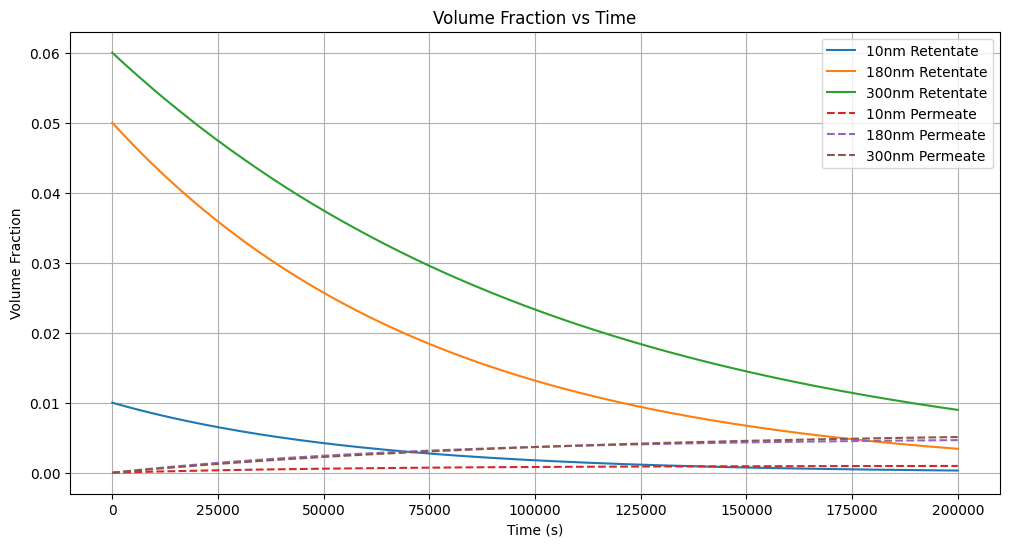

In [60]:
import matplotlib.pyplot as plt

# Plot the volume fraction against time
plt.figure(figsize=(12, 6))

# Plot retentate volume fractions
for i, p in enumerate(particles):
    plt.plot(time_points, phi_b1_solution[:, i], label=f'{p["name"]} Retentate')

# Plot permeate volume fractions
for i, p in enumerate(particles):
    plt.plot(time_points, phi_b2_solution[:, i], label=f'{p["name"]} Permeate', linestyle='--')

plt.xlabel('Time (s)')
plt.ylabel('Volume Fraction')
plt.title('Volume Fraction vs Time')
plt.legend()
plt.grid(True)
plt.show()

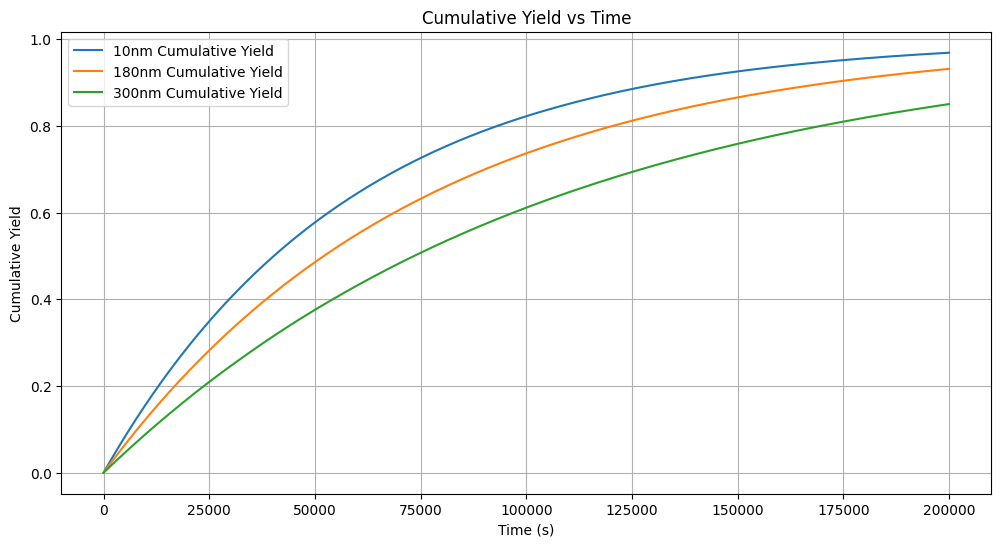

In [61]:
import matplotlib.pyplot as plt

# Plot the cumulative yield against time
plt.figure(figsize=(12, 6))

# Plot cumulative yield for each particle
for i, p in enumerate(particles):
    plt.plot(time_points, yield_fraction[:, i], label=f'{p["name"]} Cumulative Yield')

plt.xlabel('Time (s)')
plt.ylabel('Cumulative Yield')
plt.title('Cumulative Yield vs Time')
plt.legend()
plt.grid(True)
plt.show()

In [73]:
s = (( 5*eta_f* delta_membrane * L_p) /0.85)**(1/2)

In [74]:
s

2.6211474530419374e-07